&#x1f12f; Javier Bejar - APA/GEI/FIB/UPC

In [ ]:
# Uncomment to upgrade packages
# !pip3 install pandas --user --upgrade --quiet
# !pip3 install numpy --user --upgrade --quiet
# !pip3 install scipy --user --upgrade --quiet
# !pip3 install statsmodels --user --upgrade --quiet
# !pip3 install seaborn --user --upgrade --quiet
# !pip3 install matplotlib --user --upgrade --quiet
# !pip3 install scikit-learn --user --upgrade 
# !pip install scikit-optimize --user --quiet
!pip install apafib --upgrade --user --quiet
!pip install pmlb --upgrade --user --quiet

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

# APA - Laboratorio - Sesión 4
## Clasificación Lineal

In [ ]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

from sklearn.model_selection import GridSearchCV

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [ ]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

## Sección 1: Experimentación y Validación en clasificación

Igual que en los problemas de regresión, necesitamos saber qué tan bueno es nuestro modelo. 

El procedimiento para la partición de los datos en clasificación es el mismo. Reservaremos una parte de los datos como conjunto de test que no usaremos hasta el final para establecer la calidad del modelo.

Con el conjunto de validación ajustaremos los parámetros usando **validación cruzada**.
De esta manera calcularemos nuestras métricas, usaremos estas métricas comparar modelos y tomar cualquier decisión de diseño.


![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

En clasificación se puede medir la calidad del modelo de muchas maneras diferentes dependiendo de
características específicas de los datos y el problema que queramos resolver. Todas las medidas que se aplican se fijan en distintos aspectos del comportamiento del modelo.

Por lo general las medidas se definen para problemas binarios, pero se pueden generalizar a problemas en los que hay más clases. Estas medidas se definen a partir de la correspondencia entre la predicción del modelo y las clases reales. Las definiremos a partir de lo que se denomina la matriz de confusión para problemas binarios:

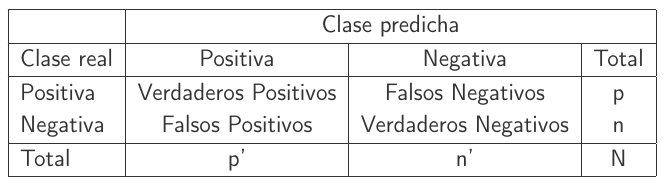

- **Error** (_error_): Porcentaje de ejemplos que se clasifican en la clase incorrecta 
  ($fp+fn/N$)
- **Acierto** (_accuracy_): Porcentaje de ejemplos que se clasifican en la clase correcta ($vp+vn/N$ = 1-error)
- **Tasa de verdaderos positivos** (_true positives rate_): $vp/p$
- **Tasa de falsos negativos** (_false negatives rate_): $fn/n$
- **precisión** (_precision_): Proporción de ejemplos verdaderos positivos respecto a los clasificados como positivos ($vp/p'$)
- **recuperación** (_recall_): Tasa de verdaderos positivos respecto a los positivos ($vp/p$)
- **F1-score**: Balance entre precisión y recuperación ($2 \frac{precision\cdot recuperacion}{precison + recupracion}$)

Durante el notebook iremos viendo como scikit-learn nos permite ver estos valores y que otras formas de selección de modelo podemos aplicar en problemas de clasificación

## Sección 2: Primer conjunto de datos (Breast Cancer - Datos continuos)

Utilizaremos primero el conjunto de datos Wisconsin Breast Cancer (https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset) que es un problema de clasificación binaria y está incluido entre los conjuntos de datos de scikit-learn.

En este caso se ha de determinar si un tumor es maligno o no

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
X, y =  load_breast_cancer(return_X_y=True, as_frame=True)

X.head()

In [ ]:
X.describe().T

El conjunto de datos está compuesto solamente por atributos numéricos.

Podemos ver el balance entre las dos clases del conjunto de datos

In [ ]:
y.value_counts()

La clase 0 corresponde con un diagóstico maligno (**M**) y la clase 1 con un diagnóstico benigno (**B**)

Particionamos los datos en conjunto de entrenamiento y conjunto de test. 

En los problemas de clasificación podemos hacer la partición estratificada, eso hace que haya aproximadamente la misma proporcion de ejemplos de cada clase en cada partición. Esto es más importante si tenemos clases proporcionalmente con pocos ejemplos.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

### Visualización

Podemos visualizar primero los atributos

In [ ]:
fig, axes = plt.subplots(10,3,figsize=(15,30))

X_train_frame = pd.DataFrame(X_train)
X_train_frame.columns=X.columns
for i, c in enumerate(X.columns):
    ax = axes.reshape(-1)[i]
    if X_train_frame[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=X_train_frame,ax=ax)
    else:
        b = sns.histplot(x=c,data=X_train_frame,ax=ax)
plt.tight_layout()

In [ ]:
corr = X_train_frame.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Podemos ver también la relación que hay entre las variables y la clase utilizando la información mutua

In [ ]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train_frame, y_train, labels=list(X_train_frame.columns),method='mutual_info-classification');

o la correlación de Pearson

In [ ]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train_frame, y_train, labels=list(X_train_frame.columns),method='pearson');

### Preproceso

Examinamos si hay valores perdidos

In [ ]:
X_train_frame.isna().sum().sort_values(ascending=False)

Dado que tenemos 30 variables podemos visualizar los datos reduciendo su dimensionalidad. Como PCA prefiere datos estandarizamos primero los transformaremos.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Visualización/Reducción de dimensionalidad

Podemos visualizar los datos reduciendo su dimensionalidad

In [ ]:
pca = PCA().fit(X_train);

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Podemos ver que la variancia explicada acumulada pasa del 85% a partir del quinto componente, los dos primeros componentes acumulan algo más del 60%, podemos intentar visualizar los datos a partir de estos

In [ ]:
X_trans = pca.transform(X_train)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train);

Podemos ver que con solo estos dos componentes se puede ver que las dos clases representan distribuciones bastante diferenciadas.

Usando una transformación no lineal como LLE podemos ver también esa separabilidad

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

In [ ]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=2)
X_trans = lle.fit_transform(X_train)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train);

### LDA

Podemos probar a clasificar los ejempos usando el discriminante lineal sobre los datos de entrenamiento


LDA intenta modelar la probabilidad $p(y=C_k|X=x)$ asumiendo:
* $p(x|C_k)$ es Gaussiano (lo que significa que puede ser descrito por $\mu_k$ y $\Sigma_k$)
* Todas las matrices de covarianza son iguales ($\Sigma_k = \Sigma$)

Aplicando maxima verosimilitud y todas estas suposiciones, obtenemos la siguiente función discriminante:

$a_k(x) = x^T\Sigma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + log(\pi_k)$

Donde $\pi_k$ son las probabilidades a priori de las clases.

Si llamamos:

$w = \Sigma^{-1}\mu_k$

$w_0=- \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + log(\pi_k)$

Obtenemos una representación lineal de la fórmula.



Procedemos a obtener el error de validación cruzada con los datos de entrenamiento

In [ ]:
lda = LinearDiscriminantAnalysis()
print(np.mean(cross_val_score(lda,X_train,y_train,cv=10)))

El acierto del modelo es bastante bueno. En este caso no tenemos ningún hiper parámetro que ajustar asi que podemos ajustar el modelo con todos los datos del conjunto de entrenamiento para ver que modelo obtenemos y después podemos comprobar como lo hace con el conjunto de test

In [ ]:
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)

print('Priors:', lda_model.priors_)
print('Means:\n')
means =pd.DataFrame(lda_model.means_)
means.columns=X.columns
means

print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
intercepts

print('Explained Variance Ratio')
pd.DataFrame(lda_model.explained_variance_ratio_ )

print('Coefs:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = X.columns
# coefs.T

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

Podemos ver en el modelo cuales son los atributos más importantes.

Para saber la calidad del modelo podemos aplicarlo a los datos de test. El _classification report_ nos dara todas las medidas que necesitamos para tomar decisiones (aunque en este caso no hay ninguna)

In [ ]:
print(classification_report(lda_model.predict(X_test), y_test,target_names=['M', 'B']))
results_df = save_results(lda_model, X_test, y_test, 'LDA', results_df)

Podemos ver el acierto del modelo es coherente con el que hemos obtenido con la validación cruzada.
 
 La clase **B** tiene una precisión mayor (menos falsos positivos) y un pocentaje parecido de ejemplos de ambas clases.

 El **macro avg** de las medidas corresponde a la media de los resultados de todas las clases, el **weighted average** pondera respecto a la proporción de cada clase.

 Podemos ver también en la matriz de confusión que errores se cometen.

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda_model, X_test,y_test, display_labels=['M', 'B'], ax=plt.subplot());

Para clasificadores probabilísticos podemos también decidir cual la probabilidad de decisión que utilizaremos para determinar la clasificación de un ejemplo en una clase u otra. Por defecto ese valor es 0.5, pero podemos variarlo dependiendo de la clase en la que nos importe o no nos importe equivocarnos.

En algunos dominios cometer errores en alguna clase es más grave que en otras, por ejemplo, en este caso es mejor clasificar en la clase **M** un ejemplo de la clase **B** que al revés.

Las consecuencias de elegir una probabilidad u otra la podemos representar en la **curva ROC** (Receiver Operating Characteristic curve) que representa la tasa de verdaderos positivos contra la de falsos positivos para diferentes puntos de corte. Sobre esta curva se calcula el **AUC** (area under the curve) que será 1 en el caso de un clasificador sin errores.

Lo que nos interesaría es un clasificador con predicción perfecta de manera que la tasa de verdaderos positivos sea 1 y la de falsos positivos sea 0. Podemos ver en la curva que punto corresponde a una tasa alta de verdaderos positivos con una tasa baja de falsos positivos.

In [ ]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(lda_model, X_test,y_test, pos_label=0, ax=plt.subplot());

Alternativamente podemos hacer lo mismo con las medidas de precisión y recuperación. Esta curva es mejor cuando hay cierto desbalance entre las clases.

In [ ]:
plt.figure(figsize=(8,8));
PrecisionRecallDisplay.from_estimator(lda_model, X_test,y_test, pos_label=0, ax=plt.subplot());

In [ ]:
from yellowbrick.classifier.threshold import discrimination_threshold

discrimination_threshold(lda_model, X_train, y_train, is_fitted=True);

Ahora podemos ver si los otros modelos suponen una mejora sobre este.

### Naïve Bayes

El modelo más sencillo es el Naive Bayes. Tenemos varias implementaciones en scikit-learn dependiendo de la distribución de probabilidad que se ajusta a los datos. En este caso los datos son continuos, podemos asumir que se distribuyen segun gausianas. El NB asume que los atributos son idependientes a diferencia de LDA donde tenemos una matriz de covariancias, aunque sea comun a todos los atributos. Esta implementacion de NB gausiano estima una matriz de covarianzas independiente por clase, asi que este modelo es equivalente a QDA con matriz de covariancias diagonal, por lo que no es un modelo lineal. 

In [ ]:
gnb = GaussianNB()
print(np.mean(cross_val_score(gnb,X_train,y_train,cv=10)))

In [ ]:
gnb_model = GaussianNB().fit(X_train, y_train)

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=X.columns
means

Podemos comprobar que los centroides que corresponden a las clases son prácticamente idénticos

In [ ]:
print(classification_report(gnb_model.predict(X_test), y_test,target_names=['M', 'B']))
results_df = save_results(gnb_model, X_test, y_test, 'GNB', results_df)

Este modelo balancea mas la precisión de cada clase, pero el acierto es prácticamente el mismo.

Podemos ver que simplemente cometemos un error más. Si nos preocupara que hubiera un balance entre la predicción entre las dos clases este sería preferible. En nuestro caso nos preocupa más una clase que la otra y este modelo al compensar las dos clases ha mejorado la clase importante.

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test,y_test, display_labels=['M', 'B'], ax=plt.subplot());

In [ ]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(gnb_model, X_test,y_test, pos_label=0, ax=plt.subplot());

## QDA

El discriminante cuadrático admite una covariancia diferente para cada una de las clases, en este caso ya no es un modelo lineal, la interpretación de los pesos del modelo no es directa.

Tenemos un parámetro en este modelo que es el que permite regularizar el discriminante. Esta regularización permite tener un modelo con covariancia diagonal en todas las clases en un extremo y un modelo donde cada clase tiene su matriz de covariancias, los valores intermedios interpolan entre esos dos casos.



Podemos explorar el rango de parámetros de la regularización, para ello hacemos una búsqueda en rejilla explorando el intervalo [0,1] en pasos de 0.1.

In [ ]:
qda = QuadraticDiscriminantAnalysis()
param = {'reg_param':np.linspace(0,1,21, endpoint=True)}
qda_gs =  GridSearchCV(qda,param,cv=5, n_jobs=-1, refit=True)
qda_gs.fit(X_train, y_train);

In [ ]:
show_html(pd.DataFrame(qda_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Podemos ver que la regularización ayuda a mejorar el acierto, podemos ajustar entonces el modelo usando ese valor para el parámetro de regularización.

In [ ]:
print(classification_report(qda_gs.predict(X_test), y_test,target_names=['M', 'B']))
results_df = save_results(qda_gs, X_test, y_test, 'QDA', results_df)

Hemos mejorado el acierto en el conjunto de test y hemos mejorado también el resto de medidas en la clase que nos interesa.

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(qda_gs, X_test,y_test, display_labels=['M', 'B'], ax=plt.subplot());

In [ ]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(qda_gs, X_test,y_test, pos_label=0, ax=plt.subplot());

### Regresión Logística

La regresión logística estima directamente  $p(y=C_k|X=x)$ evitando el tener que asumir una distribución específica para los atributos de las clases. La estimación corresponde a los ratios entre las probabilidades de las clases que se convierten en probabilidades a través de la función sigmoide. De esta manera:

$p(C|X) = \sigma(w\cdot x)$ 

Tendremos unos pesos para la función lineal, pero estos serán diferentes de los que tenemos en LDA ya que estamos representando la distribución de manera distinta.

La implementación de scikit-learn de la regresión logística nos permite aplicar regularización igual que en regresión lineal, podemos utilizar una penalización de los pesos usando L1 o L2. 


Podemos hacer una exploración en rejilla para optimizar estos dos hiperparámetros. 

Cuando tenemos mas de un hiperparámetro tenemos un numero combinatorio de posibilidades, lo que requiere una estrategia de exploración para poder probar un numero razonable de posibilidades sin caer en una explosion combinatoria. Para un conjunto de posibilidades podemos ser exhaustivos (Grid Search), pero podemos hacer también una exploración aleatoria (Random Search) o usar estrategias mas sofisticadas como veremos en otros modelos con mas hiperparametros.

En este caso el paralelizar la busqueda es crucial (le parametro n_jobs=-1 indica usar todos los cores de la maquina).

In [ ]:
lr= LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train, y_train);

In [ ]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Puede haber varios valores de hiperparametros que obtengan el mismo resultado, en ese caso elegiriamos cualquiera de entre ellos.

In [ ]:
print('Coefs:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

Como se puede ver los pesos no tienen nada que ver con los de LDA, tampoco coinciden los atributos con mayor importancia.

In [ ]:
print(classification_report(lr_gs.predict(X_test), y_test,target_names=['M', 'B']))
results_df = save_results(lr_gs, X_test, y_test, 'Logistic', results_df)

Estos son los mejores resultados, hemos aumentado la precisión y la recuperación especificamente en la clase que nos interesa y el acierto también ha aumentado

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test,y_test, display_labels=['M', 'B'], ax=plt.subplot());

Nos quedan falsos negativos de la clase **M**, se podría explorar la razón por la que se clasifican así

In [ ]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(lr_gs, X_test,y_test, pos_label=0, ax=plt.subplot());

In [ ]:
results_df.sort_values(by=['test acc'], ascending=False)

## Sección 2:  Segundo conjunto de datos (Contraceptive Method Choice - Datos Discretos)

Utilizaremos ahora el conjunto de datos Contraceptive Method Choice (https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice) que es un problema de clasificación en tres clases y se puede obtener usando la libreria PMLB (Penn Machine Learning Benchmarks).

En este caso se ha de determinar si no se usa anticonceptivos, se usa a largo plazo o a corto plazo.

Los datos son en su mayoria discretos, los que no lo son los convertiremos a discretos usando el discretizador de scikit learn.


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
from yellowbrick.classifier.rocauc import roc_auc
from pmlb import fetch_data

results_df2 = pd.DataFrame()

In [ ]:
data = fetch_data('cmc')

In [ ]:
data.head()

In [ ]:
data.describe(include='all')

In [ ]:
data['target'].value_counts()

In [ ]:
cls = [str(v) for v in sorted(data['target'].unique())]
cls

In [ ]:
data.isna().sum()

Podemos ver que la mayoria de los atributos son categóricos o binarios. No hay valores perdidos que tengamos que imputar.

Los transformaremos a ese tipo para poder usar las funciones de Pandas que obtienen el one-hot-encoding

In [ ]:
for c in data.columns:
    if c not in  ['Wifes_age', 'Number_of_children_ever_born']:
        data[c] = data[c].astype('category')

In [ ]:
X= data.iloc[:,:-1]
y= data.loc[:,'target'].copy()

In [ ]:
X.describe(include='all').T

Hacemos una partición en el conjunto de entrenamiento y test y hacemos una visualización mínima.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
fig, axes = plt.subplots(3,3,figsize=(15,12))

X_train_frame = pd.DataFrame(X_train)
X_train_frame.columns=X.columns
for i, c in enumerate(X.columns):
    ax = axes.reshape(-1)[i]
    if X_train_frame[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=X_train_frame,ax=ax)
    else:
        b = sns.histplot(x=c,data=X_train_frame,ax=ax)
plt.tight_layout()

Transformamos la dos variables que son continuas a categoricas (ordenadas).

La transformación se puede hacer de muchas maneras, podemos conocer el dominio y saber que discretización tiene sentido, o podemos hacerlo de manera automática, que es lo que haremos.

Entre las opciones que nos permite `KBinDiscetizer`usaremos la estrategia `quantile` que nos dividirá el rango de valores de manera que cada etiqueta que obtengamos corresponda a la misma masa de probabilidad.

Deberemos experimentar con diferentes valores para la discretización para ver el resultado, será otro hiperparámetro de los modelos. Aquí _mágicamente_ pondremos 6 (podéis experimentar con otros valores).

Discretizamos las dos variables, las convertimos en categóricas y las añadimos a los datos. **Siempre la transformación del test se hace con el ajuste hecho con los datos de entrenamiento.**

In [ ]:
disc = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')

X_train['Wifes_age_d']= disc.fit_transform(X_train.Wifes_age.values.reshape(-1,1))
X_test['Wifes_age_d']= disc.transform(X_test.Wifes_age.values.reshape(-1,1))
X_train['Wifes_age_d']=X_train['Wifes_age_d'].astype('category')
X_test['Wifes_age_d']=X_test['Wifes_age_d'].astype('category')

In [ ]:
disc = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')

X_train['Number_of_children_ever_born_d']= disc.fit_transform(X_train.Number_of_children_ever_born.values.reshape(-1,1))
X_test['Number_of_children_ever_born_d']= disc.transform(X_test.Number_of_children_ever_born.values.reshape(-1,1))
X_train['Number_of_children_ever_born_d']=X_train['Number_of_children_ever_born_d'].astype('category')
X_test['Number_of_children_ever_born_d']=X_test['Number_of_children_ever_born_d'].astype('category')

y nos deshacemos de las columnas originales

In [ ]:
X_train.drop(columns=['Wifes_age','Number_of_children_ever_born'], inplace=True)
X_test.drop(columns=['Wifes_age','Number_of_children_ever_born'], inplace=True)

### Versión atributos binarios

Ahora generamos un conjunto de datos con atributos binarizados usando one hot encoding (eliminando una de las categorías para no añadir columnas que sean combinación lineal de otras)

In [ ]:
X_train_d = pd.get_dummies(X_train, drop_first=True)
y_train_d = y_train.cat.codes 
X_test_d = pd.get_dummies(X_test, drop_first=True)
y_test_d = y_test.cat.codes 

In [ ]:
X_train_d.describe(include='all')

In [ ]:
X_test_d.shape

Podemos observar la correlación entre las variables

In [ ]:
corr = X_train_d.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [ ]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train_d, y_train_d, labels=list(X_train_d.columns),method='mutual_info-classification');

Haremos diferentes visualizaciones para detectar algún tipo de patron en los datos respecto a las clases al proyectarlos en baja dimensionalidad.

Empezaremos con PCA, pero hay que tener en cuenta que este modelo asume datos gausianos y estamos trabajando con datos binarios.

In [ ]:
pca = PCA().fit(X_train_d);

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Ya podemos comprobar que la variancia está muy distribuida en todas las componentes, asi que la visualicación en 2D puede no decirnos mucho.

In [ ]:
X_trans = pca.transform(X_train_d)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train_d);

No parece haber patrones claros en la representación.

Podemos usar LLE y t-SNE que trabajan con distancias y permiten tener en cuenta no linearidades en los datos.

Para LLE deberíamos explorar el número de vecinos que se usa para el cálculo.

In [ ]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=12)
X_trans = lle.fit_transform(X_train_d)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train_d);

In [ ]:
from sklearn.manifold import TSNE

X_trans = TSNE(n_components=2, perplexity=10,n_iter=2000, init='pca').fit_transform(X_train_d)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train_d);

Ninguna de las visualizaciones da un patrón de grupos claro que tenga alguna relación con las clases, esto nos puede indicar que el conjunto de datos puede ser bastante dificil de clasificar correctamente al menos con los atributos que tenemos.

Empezaremos usando Naive Bayes modelando las variables binarias como distribuciones de Bernoulli

In [ ]:
bnb = BernoulliNB()
print(np.mean(cross_val_score(bnb,X_train_d,y_train_d,cv=10)))

El error de validación cruzada parece bastante terrible, pero hemos de tener en cuenta que estamos asumiendo que las variables son independientes. No tenemos hiper parámetros que ajustar, asi que este es el único modelo que tenemos.

Ajustamos el modelo con todos los datos de entrenamiento.

In [ ]:
bnb_model = BernoulliNB().fit(X_train_d, y_train_d)

In [ ]:
print(classification_report(bnb_model.predict(X_test_d), y_test_d,target_names=cls))
results_df2 = save_results(bnb_model, X_test_d, y_test_d, 'BNB (b)', results_df2)

El acierto con el conjunto de test es parecido al de validación cruzada, ninguna de las clases tiene unos valores demasiado buenos, la clase 3 parece la peor de todas.

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(bnb_model, X_test_d,y_test_d, display_labels=cls, ax=plt.subplot());

La curva ROC es más complicada de entender cuando hay más de dos categorías, la librería `yellowbrick` permite dibujarla. Esta nos muestra la tasa de vp/fp de una clase respecto al resto y una media/media ponderada. Podemos ver que las AUC no son demasiado buenos como podíamos esperar.

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(bnb_model, X_train_d, y_train_d, X_test_d, y_test_d, classes=cls);

Podemos aplicar regresión logística sobre el conjunto de datos, aquí como hemos visto estamos modelando directamente el ratio de probabilidades entre las clases. 

In [ ]:
lr = LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,51, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train_d, y_train_d);

In [ ]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Podemos ver que hemos avanzado algo respecto al modelo NB, pero tampoco es un modelo fantástico. Podemos visualizar los pesos para ver que tiene más importancia en la clasificación.

In [ ]:
print('Coefs:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train_d.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':10});

In [ ]:
print(classification_report(lr_gs.predict(X_test_d), y_test_d,target_names=cls))
results_df2 = save_results(lr_gs, X_test_d, y_test_d, 'Logistic (b)', results_df2)

Podemos ver que la calidad de predicción entre clases ha cambiado algo, aunque aun deja bastante que desear.

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_d,y_test_d, display_labels=cls, ax=plt.subplot());

La AUC también ha mejorado algo como es de esperar.

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(lr_gs, X_train_d, y_train_d, X_test_d, y_test_d, classes=cls);

### Versión atributos categóricos

Podemos ver que pasa si asumimos una distribución distinta sobre los datos, por ejemplo usándolos como categóricos, que es su representación inicial. 

Generamos un nuevo conjunto de datos usando la codificiación que pandas asigna a las variables,

In [ ]:
X_train_c = pd.DataFrame()
X_test_c = pd.DataFrame()
for c in X_train.columns[1:]:
        X_train_c[c] = X_train[c].cat.codes 
        X_test_c[c] = X_test[c].cat.codes 

y_train_c = y_train.cat.codes 
y_test_c = y_test.cat.codes 

scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train_c)
y_train_s = y_train.cat.codes 

X_test_s = scaler.transform(X_test_c)
y_test_s = y_test.cat.codes 

Podemos observar ahora la correlación entre variables y con la variable respuesta

In [ ]:
corr = X_train_c.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [ ]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train_c, y_train_c, labels=list(X_train_c.columns),method='mutual_info-classification');

Visualizando el PCA podemos ver que tenemos un espacio bastante distinto

In [ ]:
X_trans = pca.fit_transform(X_train_c)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train_c);

Aplicado TSNE tenemos algo más continuo

In [ ]:
X_trans = TSNE(n_components=2, perplexity=10,n_iter=2000, init='pca').fit_transform(X_train_c)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train_c);

Usamos la versión de naive bayes que asume atributos categóricos (no ordenados)

In [ ]:
cnb = CategoricalNB()
print(np.mean(cross_val_score(cnb,X_train_c,y_train_c,cv=10)))

In [ ]:
cnb_model = CategoricalNB().fit(X_train_c, y_train_c)

In [ ]:
print(classification_report(cnb_model.predict(X_test_c), y_test_c,target_names=cls))
results_df2 = save_results(cnb_model, X_test_c, y_test_c, 'CNB (c)', results_df2)

Podemos ver que ganamos algo respecto a la versión binarizada, pero no llega al resultado de la regresión logística

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(cnb_model, X_test_c,y_test_c, display_labels=cls, ax=plt.subplot());

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(cnb_model, X_train_c, y_train_c, X_test_c, y_test_c, classes=cls);

Podemos ver si el cambio de representación tiene algún efecto sobre la regresión logística.

En este caso la regresión logística considerará el orden. Lo habitual es que los datos para regresión logística esten escalados que es lo he hemos hecho al principio, ayuda a la convergencia del algoritmo

In [ ]:
lr = LogisticRegression()
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,51, endpoint=True)}
lrc_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lrc_gs.fit(X_train_s, y_train_s);

In [ ]:
show_html(pd.DataFrame(lrc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [ ]:
print(classification_report(lrc_gs.predict(X_test_s), y_test_s,target_names=cls))
results_df2 = save_results(lrc_gs, X_test_s, y_test_s, 'Logistic (c)', results_df2)

No parece que haya ayudado mucho, el resultado es algo peor, sobre todo en la segunda clase.

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lrc_gs, X_test_s,y_test_s, display_labels=cls, ax=plt.subplot());

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(lrc_gs, X_train_s, y_train_s, X_test_s, y_test_s, classes=cls);

No hay ningun modelo que sea demasiado bueno, entre los cuatro elegiríamos la regresión logística con atributos binarios al tener mejores puntuaciones globales, pero podría ser en el dominio alguna clase más importante que otra, lo que nos podría hacer cambiar de opinión.


In [ ]:
results_df2.sort_values(by=['test acc'], ascending=False)


El siguiente paso debería ser el comprobar si algún modelo no lineal permite obtener un mejor resultado.

In [ ]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")